In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
import sys
sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))

from methods.utils import dynamic
from methods import mmca, mcmc
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [3]:
# 导入默认参数
file_path = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), 'parameters/inital_data_1.pkl')
with open(file_path, 'rb') as f:
    init_data = pickle.load(f)

epi_paras = torch.tensor(init_data['epi_paras'], dtype=torch.float32).to(device)
soc_paras = torch.tensor(init_data['soc_paras'], dtype=torch.float32).to(device)
features_state = torch.tensor(init_data['init_state'], dtype=torch.float32).to(device)
features_prob = torch.tensor(init_data['init_prob'], dtype=torch.float32).to(device)
P_rows, P_cols = init_data['P_matrix'].nonzero()
P_edge_index = torch.tensor(np.array([P_rows, P_cols]), dtype=torch.long).to(device)
I_rows, I_cols = init_data['I_matrix'].nonzero()
I_edge_index = torch.tensor(np.array([I_rows, I_cols]), dtype=torch.long).to(device)

In [4]:
# 讨论 beta 对mcmc和mmca轨迹的差异
# mcmc_beta
para_len = 16
node_num = features_state.shape[0]

soc_paras_beta_mcmc = soc_paras.unsqueeze(0).repeat(para_len, 1)
epi_paras_beta_mcmc = epi_paras.unsqueeze(0).repeat(para_len, 1, 1) 

features_state_tensor = features_state.unsqueeze(0).repeat(para_len, 1, 1).to(device)

delta_t = 0.1
mcmc_method = mcmc.MCMC(para_len, node_num, device, delta_t)
time_scale = int(50/delta_t)


betas = torch.tensor([0.1, 0.4, 0.7])
features_times_beta_mcmc = torch.zeros(betas.shape[0], time_scale+1, 5)
for i in range(betas.shape[0]):
    epi_paras_beta_mcmc[...,0] = betas[i]
    features_times, _ = dynamic(time_scale, mcmc_method, features_state_tensor.clone(), epi_paras_beta_mcmc,\
                                 soc_paras_beta_mcmc, P_edge_index, I_edge_index, device)
    features_times_beta_mcmc[i] = torch.mean(features_times,dim=0)

# mmca_beta
para_len = betas.shape[0]
soc_paras_beta_mmca = soc_paras.unsqueeze(0).repeat(para_len, 1)
epi_paras_beta_mmca = epi_paras.unsqueeze(0).repeat(para_len, 1, 1) 

for i in range(betas.shape[0]):
    epi_paras_beta_mmca[i,:,0] = betas[i]
    
features_prob_tensor = features_prob.unsqueeze(0).repeat(para_len, 1, 1).to(device)
mmca_method = mmca.MMCA(device, delta_t)

features_times_beta_mmca, _ = dynamic(time_scale, mmca_method, features_prob_tensor, epi_paras_beta_mmca,\
                                       soc_paras_beta_mmca, P_edge_index, I_edge_index, device)

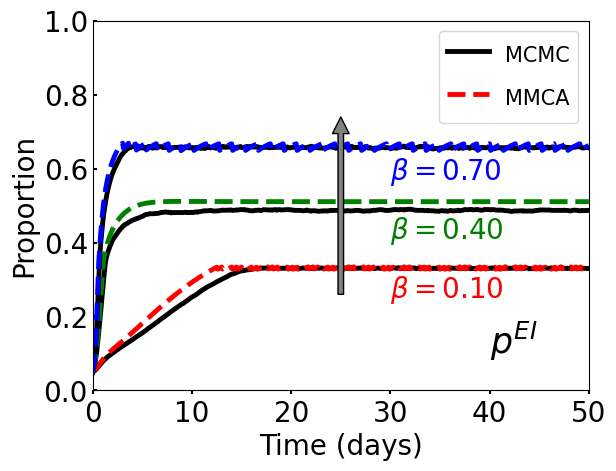

In [5]:
# beta 可视化
time_data = np.arange(0.0, (time_scale+1)/10, 0.1)
data1 = features_times_beta_mcmc[0]
data2 = features_times_beta_mcmc[1]
data3 = features_times_beta_mcmc[2]

data1_mmca = features_times_beta_mmca[0]
data2_mmca = features_times_beta_mmca[1]
data3_mmca = features_times_beta_mmca[2]

fig, ax = plt.subplots()

ax.plot(time_data, torch.sum(data1[:,[2,3,4]],dim=1), color='black', linewidth=3.5, linestyle='-', label='MCMC')
ax.plot(time_data, torch.sum(data1_mmca[:,[2,3,4]],dim=1), color='red', linewidth=3.5, linestyle='--',label='MMCA')

ax.plot(time_data, torch.sum(data2[:,[2,3,4]],dim=1), color='black', linewidth=3.5, linestyle='-')
ax.plot(time_data, torch.sum(data2_mmca[:,[2,3,4]],dim=1), color='green', linewidth=3.5, linestyle='--')

ax.plot(time_data, torch.sum(data3[:,[2,3,4]],dim=1), color='black', linewidth=3.5, linestyle='-')
ax.plot(time_data, torch.sum(data3_mmca[:,[2,3,4]],dim=1), color='blue', linewidth=3.5, linestyle='--')

# 添加箭头
ax.annotate('', xy=(25, 0.9), xytext=(25, 0.10),
            arrowprops=dict(facecolor='gray', shrink=0.2))

# 添加文本标签
ax.text(40, 0.10, r'$p^{EI}$', fontsize=25, color='black')

ax.text(30, 0.25, r'$\beta = $'+f'{betas[0]:.2f}', fontsize=20, color='red')
ax.text(30, 0.41, r'$\beta = $'+f'{betas[1]:.2f}', fontsize=20, color='green')
ax.text(30, 0.57, r'$\beta = $'+f'{betas[2]:.2f}', fontsize=20, color='blue')

# 设置坐标轴标签
ax.set_xlabel('Time (days)', fontsize=20, color='black')
ax.set_ylabel('Proportion', fontsize=20, color='black')
ax.tick_params(axis='x', labelsize=20, length=3, width=1.5, color='black', direction='out')
ax.tick_params(axis='y', labelsize=20, length=3, width=1.5, color='black', direction='in')
ax.set_xlim(0, time_scale/10)
ax.set_ylim(0, 1)

# 设置顶部文字
# ax.text(-0.15, 1.05, '(a)', fontsize=20, transform=ax.transAxes)
ax.legend(fontsize=15, handlelength=2, handleheight=2)

# 显示图形
plt.show()

fig.savefig(f'../figs/Num_verification/features_times_beta_trajectory.svg', bbox_inches='tight')

In [6]:
# 讨论 lam 对mcmc和mmca轨迹的差异
# mcmc_lam
para_len = 16
node_num = features_state.shape[0]

soc_paras_lam_mcmc = soc_paras.unsqueeze(0).repeat(para_len, 1)
epi_paras_lam_mcmc = epi_paras.unsqueeze(0).repeat(para_len, 1, 1) 

features_state_tensor = features_state.unsqueeze(0).repeat(para_len, 1, 1).to(device)
mcmc_method = mcmc.MCMC(para_len, node_num, device)

lams = torch.tensor([0.1, 0.4, 0.7])
features_times_lam_mcmc = torch.zeros(lams.shape[0], time_scale+1, 5)
for i in range(lams.shape[0]):
    epi_paras_lam_mcmc[...,3] = lams[i]
    features_times, _ = dynamic(time_scale, mcmc_method, features_state_tensor.clone(), epi_paras_lam_mcmc,\
                                 soc_paras_lam_mcmc, P_edge_index, I_edge_index, device)
    features_times_lam_mcmc[i] = torch.mean(features_times,dim=0)

# mmca_lam
para_len = lams.shape[0]
soc_paras_lam_mmca = soc_paras.unsqueeze(0).repeat(para_len, 1)
epi_paras_lam_mmca = epi_paras.unsqueeze(0).repeat(para_len, 1, 1) 

for i in range(lams.shape[0]):
    epi_paras_lam_mmca[i,:,3] = lams[i]
    
features_prob_tensor = features_prob.unsqueeze(0).repeat(para_len, 1, 1).to(device)
mmca_method = mmca.MMCA(device)

features_times_lam_mmca, _ = dynamic(time_scale, mmca_method, features_prob_tensor, epi_paras_lam_mmca,\
                                      soc_paras_lam_mmca, P_edge_index, I_edge_index, device)

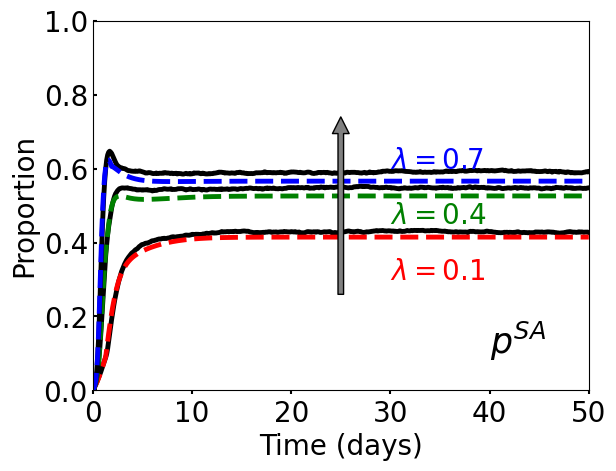

In [7]:
# lam 可视化
time_data = np.arange(0.0, (time_scale+1)/10, 0.1)
data1 = features_times_lam_mcmc[0]
data2 = features_times_lam_mcmc[1]
data3 = features_times_lam_mcmc[2]

data1_mmca = features_times_lam_mmca[0]
data2_mmca = features_times_lam_mmca[1]
data3_mmca = features_times_lam_mmca[2]

fig, ax = plt.subplots()

ax.plot(time_data, torch.sum(data1[:,[1]],dim=1), color='black', linewidth=3.5, linestyle='-', label='MCMC')
ax.plot(time_data, torch.sum(data1_mmca[:,[1]],dim=1), color='red', linewidth=3.5, linestyle='--',label='MMCA')

ax.plot(time_data, torch.sum(data2[:,[1]],dim=1), color='black', linewidth=3.5, linestyle='-')
ax.plot(time_data, torch.sum(data2_mmca[:,[1]],dim=1), color='green', linewidth=3.5, linestyle='--')

ax.plot(time_data, torch.sum(data3[:,[1]],dim=1), color='black', linewidth=3.5, linestyle='-')
ax.plot(time_data, torch.sum(data3_mmca[:,[1]],dim=1), color='blue', linewidth=3.5, linestyle='--')

# 添加箭头
ax.annotate('', xy=(25, 0.8), xytext=(25, 0.2),
            arrowprops=dict(facecolor='gray', shrink=0.1))

# 添加文本标签
ax.text(40, 0.10, r'$p^{SA}$', fontsize=25, color='black')

ax.text(30, 0.30, r'$\lambda = $'+f'{lams[0]:.1f}', fontsize=20, color='red')
ax.text(30, 0.45, r'$\lambda = $'+f'{lams[1]:.1f}', fontsize=20, color='green')
ax.text(30, 0.60, r'$\lambda = $'+f'{lams[2]:.1f}', fontsize=20, color='blue')

# 设置坐标轴标签
ax.set_xlabel('Time (days)', fontsize=20, color='black')
ax.set_ylabel('Proportion', fontsize=20, color='black')
ax.tick_params(axis='x', labelsize=20, length=3, width=1.5, color='black', direction='out')
ax.tick_params(axis='y', labelsize=20, length=3, width=1.5, color='black', direction='in')
ax.set_xlim(0, time_scale/10)
ax.set_ylim(0, 1)

# 设置顶部文字
# ax.text(-0.15, 1.05, '(a)', fontsize=20, transform=ax.transAxes)
# ax.legend(fontsize=15, handlelength=2, handleheight=2)

# 显示图形
plt.show()

fig.savefig(f'../figs/Num_verification/features_times_lam_trajectory.svg', bbox_inches='tight')

In [7]:
# xlm, xmh, gl, gm, gh = 1.0, 1.0, 0.1, 0.5, 0.9 # obs-->ga
# xlm, xmh, gl, gm, gh = 1/2, 1/2, 0.1, 0.5, 0.9 # obs-->ga
xlm, xmh, gl, gm, gh = 1/3, 2/3, 0.1, 0.5, 0.9 # obs-->ga
kgm, kgh = 0.5, 0.5 # ga-->ma, ga-->ha
soc_paras_beta_lam = np.array([xlm, xmh, gl, gm, gh, kgm, kgh])
soc_paras_beta_lam =  torch.tensor(soc_paras_beta_lam, dtype=torch.float32).to(device)

In [ ]:
para_len = 64

soc_paras_beta_lam_mcmc = soc_paras.unsqueeze(0).repeat(para_len, 1)
epi_paras_beta_lam_mcmc = epi_paras.unsqueeze(0).repeat(para_len, 1, 1) 

features_state_tensor = features_state.unsqueeze(0).repeat(para_len, 1, 1).to(device)

delta_t = 0.1
mcmc_method = mcmc.MCMC(30, node_num, device, delta_t)
time_scale = int(30/delta_t)

beta_values = 10 ** torch.linspace(-2, 0, para_len)
lam_values = 10 ** torch.linspace(-2, 0, para_len)

beta_lam_phase = torch.zeros(para_len,para_len,5)

process = 0
for i in range(beta_values.shape[0]):
    for j in range(lam_values.shape[0]):
        epi_paras_beta_lam_mcmc[...,0] = beta_values[i]
        epi_paras_beta_lam_mcmc[...,3] = lam_values[j]
        features_times, _ = dynamic(time_scale, mcmc_method, features_state_tensor.clone(), epi_paras_beta_lam_mcmc,\
                                    soc_paras_beta_lam_mcmc, P_edge_index, I_edge_index, device)
        beta_lam_phase[i,j,:] = torch.mean(torch.mean(features_times,dim=0)[-100:,:],dim =0)
    process += 1
    print(f'已经完成第 {process} 个数据！')
torch.save(beta_lam_phase.cpu(), 'data/beta_lam_phase_mcmc.pt')

C:\Users\95406\AppData\Local\Temp\ipykernel_40784\1725508958.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  beta_lam_phase = torch.load('data/beta_lam_phase_mcmc.pt')


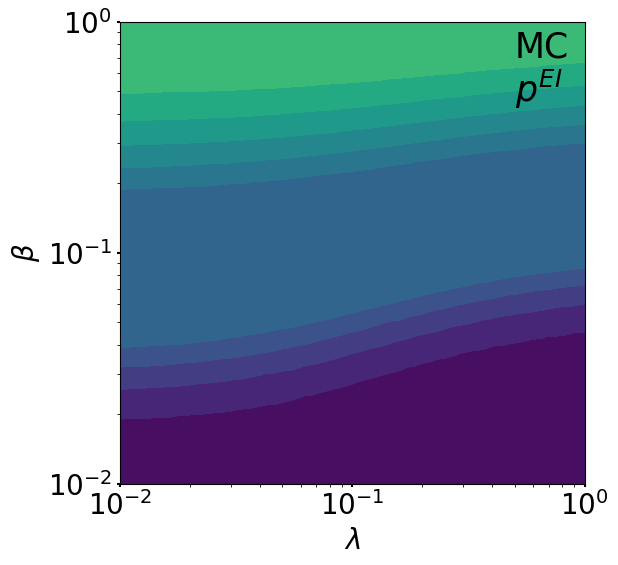

In [13]:
beta_lam_phase = torch.load('data/beta_lam_phase_mcmc.pt')

data = torch.sum(beta_lam_phase[...,[2,3,4]],dim=-1)

# 绘制相图
plt.figure(figsize=(6, 6))  # 设置图像大小
# 使用 beta_values 和 lam_values 作为横纵坐标
X, Y = np.meshgrid(lam_values, beta_values)
plt.contourf(X, Y, data, levels=np.linspace(0,  1.0, 15), cmap='viridis', origin='lower')  # 填充等高线图
# cbar = plt.colorbar( orientation='vertical', shrink=0.9, pad=0.02)  # 添加颜色条
# cbar.set_ticks(np.linspace(0,  0.96, 5))
# cbar.set_label('Proportion', fontsize=15) 
# cbar.ax.tick_params(labelsize=13, length=6, width=1.5)
# 绘制数值等于 0.01 的等高线
# contour = plt.contour(X, Y, data, levels=[0.3], colors='red', linewidths=2)
# manual_locations = [(0.1, 0.01)]
# plt.clabel(contour, inline=True, fontsize=15, inline_spacing=0.1, manual=manual_locations)  # 在等高线上添加标签
# 设置横纵坐标的刻度为对数刻度
plt.xscale('log')
plt.yscale('log')
# plt.title('Phase Diagram with Log Scale')  # 添加标题
plt.ylabel(r'$\beta$', fontsize=20)  # X轴标签
plt.xlabel(r'$\lambda$', fontsize=20)  # Y轴标签
plt.tick_params(axis='both', which='major', labelsize=20, length=2, width=1.5)
plt.text(0.5, 0.45, r'$p^{EI}$', fontsize=25, color='black')
plt.text(0.5, 0.7, 'MC', fontsize=25, color='black')

# 添加箭头
# plt.annotate('', xy=(0.05, 0.1), xytext=(0.05, 0.004),
#             arrowprops=dict(connectionstyle='arc3',width=7, headwidth=20, headlength=20,
#                              shrink=0.1, fc='lightblue', ec='black', alpha=0.8))
# plt.text(0.02, 0.1, 'More infection', fontsize=20, color='black')

# plt.show()
plt.savefig(f'../figs/Num_verification/features_times_beta_lam_phase_mcmc_EI.svg', bbox_inches='tight')
plt.savefig(f'../figs/Num_verification/features_times_beta_lam_phase_mcmc_EI.png', dpi=600)

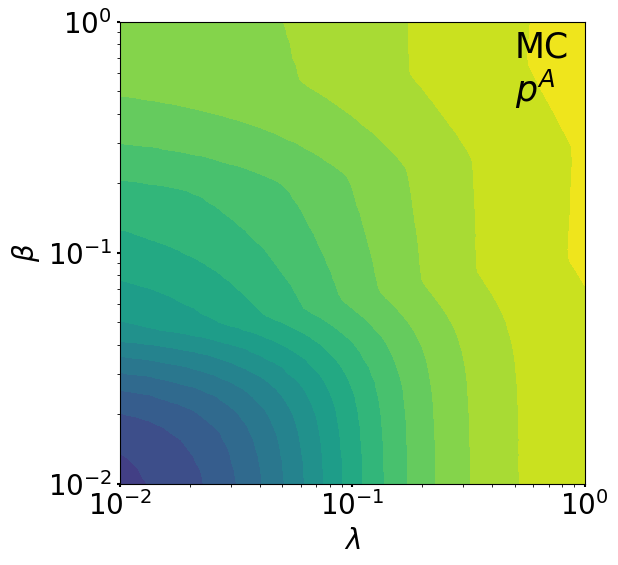

In [14]:
data = torch.sum(beta_lam_phase[...,[1,3,4]],dim=-1)

# 绘制相图
plt.figure(figsize=(6, 6))  # 设置图像大小
# 使用 beta_values 和 lam_values 作为横纵坐标
X, Y = np.meshgrid(lam_values, beta_values)
plt.contourf(X, Y, data, levels=np.linspace(0, 1.0, 20), cmap='viridis', origin='lower')  # 填充等高线图

# cbar = plt.colorbar( orientation='vertical', shrink=0.9, pad=0.02)  # 添加颜色条
# cbar.set_ticks(np.linspace(0, 1.0, 5))
# cbar.set_label('Proportion', fontsize=15) 
# cbar.ax.tick_params(labelsize=13, length=6, width=1.5)

# 绘制数值 的等高线
# levels = 0.5
# plt.text(0.03, 0.035, f'{levels}', fontsize=20, color='red')
# contour = plt.contour(X, Y, data, levels=[levels], colors='red', linewidths=2)

# 设置横纵坐标的刻度为对数刻度
plt.xscale('log')
plt.yscale('log')
# plt.title('Phase Diagram with Log Scale')  # 添加标题
plt.ylabel(r'$\beta$', fontsize=20)  # X轴标签
plt.xlabel(r'$\lambda$', fontsize=20)  # Y轴标签
plt.tick_params(axis='both', which='major', labelsize=20, length=2, width=1.5)
plt.text(0.5, 0.45, r'$p^{A}$', fontsize=25, color='black')
plt.text(0.5, 0.7, 'MC', fontsize=25, color='black')
# 添加箭头
# plt.annotate('', xy=(0.2, 0.2), xytext=(0.02, 0.02),
#             arrowprops=dict(connectionstyle='arc3',width=7, headwidth=20, headlength=20,
#                              shrink=0.1, fc='lightblue', ec='black', alpha=0.8))
# plt.text(0.08, 0.015, 'More aware', fontsize=20, color='black')

# plt.show()

plt.savefig(f'../figs/Num_verification/features_times_beta_lam_phase_mcmc_A.svg', bbox_inches='tight')
plt.savefig(f'../figs/Num_verification/features_times_beta_lam_phase_mcmc_A.png', dpi=600)

In [11]:
# beta-lam phase
para_len = 64

soc_paras_beta_lam_mmca = soc_paras_beta_lam.unsqueeze(0).repeat(para_len, 1)
epi_paras_beta_lam_mmca = epi_paras.unsqueeze(0).repeat(para_len, 1, 1) 

features_prob_tensor = features_prob.unsqueeze(0).repeat(para_len, 1, 1).to(device)
mmca_method = mmca.MMCA(device)

beta_values = 10 ** torch.linspace(-2, 0, para_len)
lam_values = 10 ** torch.linspace(-2, 0, para_len)

beta = beta_values.unsqueeze(1).expand(-1, node_num).to(device)
epi_paras_beta_lam_mmca[...,0] = beta

beta_lam_phase = torch.zeros(para_len,para_len,5)

In [ ]:
process = 0
for i in range(lam_values.shape[0]):
    epi_paras_beta_lam_mmca[...,3] = lam_values[i]
    features_times_beta_lam_mmca, _ = dynamic(time_scale, mmca_method, features_prob_tensor.clone(), epi_paras_beta_lam_mmca,\
                                                   soc_paras_beta_lam_mmca, P_edge_index, I_edge_index, device)
    beta_lam_phase[:,i,:] = features_times_beta_lam_mmca[:,-1,:]
    process += 1
    print(f'已经完成第 {process} 个数据！')
# torch.save(beta_lam_phase.cpu(), 'data/beta_lam_phase0.pt')
# torch.save(beta_lam_phase.cpu(), 'data/beta_lam_phase1.pt')
torch.save(beta_lam_phase.cpu(), 'data/beta_lam_phase_mmca2.pt')

C:\Users\95406\AppData\Local\Temp\ipykernel_40784\3058233963.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  beta_lam_phase = torch.load('data/beta_lam_phase_mmca2.pt')


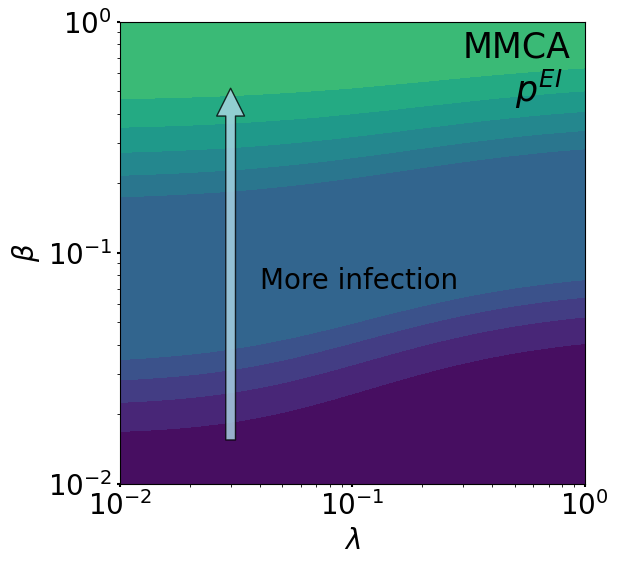

In [15]:
# beta_lam_phase = torch.load('data/beta_lam_phase0.pt')
# beta_lam_phase = torch.load('data/beta_lam_phase1.pt')
beta_lam_phase = torch.load('data/beta_lam_phase_mmca2.pt')

data = torch.sum(beta_lam_phase[...,[2,3,4]],dim=-1)

# 绘制相图
plt.figure(figsize=(6, 6))  # 设置图像大小
# 使用 beta_values 和 lam_values 作为横纵坐标
X, Y = np.meshgrid(lam_values, beta_values)
plt.contourf(X, Y, data, levels=np.linspace(0,  1.00, 15), cmap='viridis', origin='lower')  # 填充等高线图
# cbar = plt.colorbar( orientation='vertical', shrink=0.9, pad=0.02)  # 添加颜色条
# cbar.set_ticks(np.linspace(0, 0.7, 5))
# cbar.set_label('Proportion', fontsize=15) 
# cbar.ax.tick_params(labelsize=13, length=6, width=1.5)
# 绘制数值等于 0.01 的等高线
# contour = plt.contour(X, Y, data, levels=[0.3], colors='red', linewidths=2)
# manual_locations = [(0.1, 0.01)]
# plt.clabel(contour, inline=True, fontsize=15, inline_spacing=0.1, manual=manual_locations)  # 在等高线上添加标签
# 设置横纵坐标的刻度为对数刻度
plt.xscale('log')
plt.yscale('log')
# plt.title('Phase Diagram with Log Scale')  # 添加标题
plt.ylabel(r'$\beta$', fontsize=20)  # X轴标签
plt.xlabel(r'$\lambda$', fontsize=20)  # Y轴标签
plt.tick_params(axis='both', which='major', labelsize=20, length=2, width=1.5)
plt.text(0.5, 0.45, r'$p^{EI}$', fontsize=25, color='black')
plt.text(0.3, 0.7, 'MMCA', fontsize=25, color='black')
# # 添加箭头
plt.annotate('', xy=(0.03, 0.8), xytext=(0.03, 0.01),
            arrowprops=dict(connectionstyle='arc3',width=7, headwidth=20, headlength=20,
                             shrink=0.1, fc='lightblue', ec='black', alpha=0.8))
plt.text(0.04, 0.07, 'More infection', fontsize=20, color='black')

# plt.show()
plt.savefig(f'../figs/Num_verification/features_times_beta_lam_phase_mmca_EI.svg', bbox_inches='tight')
plt.savefig(f'../figs/Num_verification/features_times_beta_lam_phase_mmca_EI.png', dpi=600)

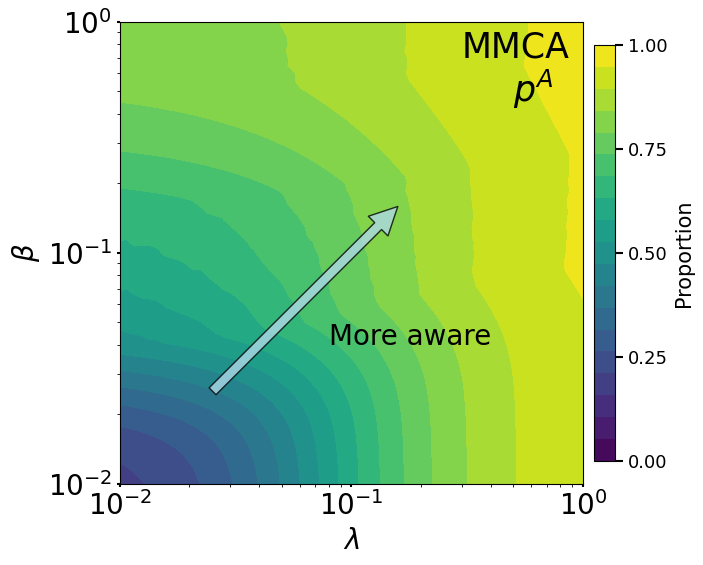

In [17]:
data = torch.sum(beta_lam_phase[...,[1,3,4]],dim=-1)

# 绘制相图
plt.figure(figsize=(7.2, 6))  # 设置图像大小
# 使用 beta_values 和 lam_values 作为横纵坐标
X, Y = np.meshgrid(lam_values, beta_values)
plt.contourf(X, Y, data, levels=np.linspace(0, 1.0, 20), cmap='viridis', origin='lower')  # 填充等高线图

cbar = plt.colorbar( orientation='vertical', shrink=0.9, pad=0.02)  # 添加颜色条
cbar.set_ticks(np.linspace(0, 1.0, 5))
cbar.set_label('Proportion', fontsize=15) 
cbar.ax.tick_params(labelsize=13, length=6, width=1.5)

# 绘制数值 的等高线
# levels = 0.5
# plt.text(0.03, 0.035, f'{levels}', fontsize=20, color='red')
# contour = plt.contour(X, Y, data, levels=[levels], colors='red', linewidths=2)

# 设置横纵坐标的刻度为对数刻度
plt.xscale('log')
plt.yscale('log')
# plt.title('Phase Diagram with Log Scale')  # 添加标题
plt.ylabel(r'$\beta$', fontsize=20)  # X轴标签
plt.xlabel(r'$\lambda$', fontsize=20)  # Y轴标签
plt.tick_params(axis='both', which='major', labelsize=20, length=2, width=1.5)
plt.text(0.5, 0.45, r'$p^{A}$', fontsize=25, color='black')
plt.text(0.3, 0.7, 'MMCA', fontsize=25, color='black')
# 添加箭头
plt.annotate('', xy=(0.2, 0.2), xytext=(0.02, 0.02),
            arrowprops=dict(connectionstyle='arc3',width=7, headwidth=20, headlength=20,
                             shrink=0.1, fc='lightblue', ec='black', alpha=0.8))
plt.text(0.08, 0.04, 'More aware', fontsize=20, color='black')

# plt.show()

plt.savefig(f'../figs/Num_verification/features_times_beta_lam_phase_mmca_A.svg', bbox_inches='tight')
plt.savefig(f'../figs/Num_verification/features_times_beta_lam_phase_mmca_A.png', dpi=600)

In [19]:
beta_values = 10 ** torch.linspace(-2, 0, para_len)
lam_values = 10 ** torch.linspace(-2, 0, para_len)
beta_lam_mcmc_phase = torch.load('data/beta_lam_phase_mcmc.pt')
pEI_mcmc = torch.sum(beta_lam_mcmc_phase[...,[2,3,4]],dim=-1)
pA_mcmc = torch.sum(beta_lam_mcmc_phase[...,[1,3,4]],dim=-1)

beta_lam_mmca_phase = torch.load('data/beta_lam_phase_mmca2.pt')
pEI_mmca = torch.sum(beta_lam_mmca_phase[...,[2,3,4]],dim=-1)
pA_mmca = torch.sum(beta_lam_mmca_phase[...,[1,3,4]],dim=-1)

print(torch.mean(torch.abs(pEI_mcmc - pEI_mmca)/(pEI_mcmc)))

tensor(0.0972)


C:\Users\95406\AppData\Local\Temp\ipykernel_40784\3576782511.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  beta_lam_mcmc_phase = torch.load('data/beta_lam_phase_mcmc.p

C:\Users\95406\AppData\Local\Temp\ipykernel_40784\3901461636.py:48: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(0, 1)


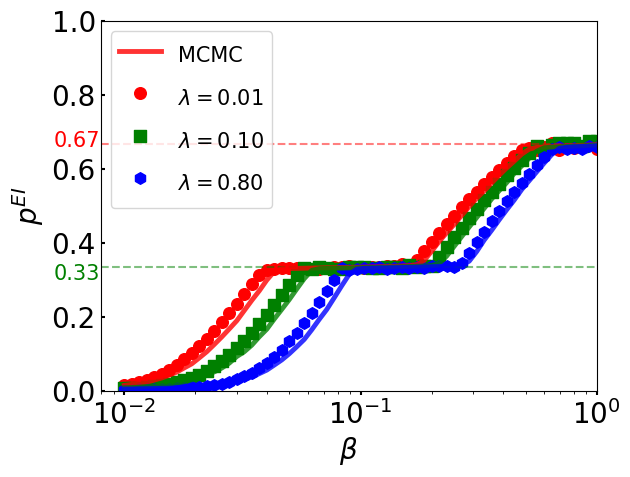

In [21]:
index_lam = [0,32,60]
# lam 可视化
beta_data = beta_values
data1 = pEI_mcmc[:,index_lam[0]]
data2 = pEI_mcmc[:,index_lam[1]]
data3 = pEI_mcmc[:,index_lam[2]]

data1_mmca = pEI_mmca[:,index_lam[0]]
data2_mmca = pEI_mmca[:,index_lam[1]]
data3_mmca = pEI_mmca[:,index_lam[2]]

fig, ax = plt.subplots()

ax.plot(beta_data, data1, color='red', linewidth=3.5, linestyle='-', label='MCMC', alpha=0.8)
ax.scatter(beta_data, data1_mmca, color='red', s=70,  marker='o'
           ,label=r'$\lambda = $'+f'{beta_values[index_lam[0]]:.2f}')

ax.plot(beta_data, data2, color='green', linewidth=3.5, linestyle='-', alpha=0.8)
ax.scatter(beta_data, data2_mmca, color='green', s=70,  marker='s',
           label=r'$\lambda = $'+f'{beta_values[index_lam[1]]:.2f}')

ax.plot(beta_data, data3, color='blue', linewidth=3.5, linestyle='-', alpha=0.8)
ax.scatter(beta_data, data3_mmca, color='blue', s=70,  marker='h',
           label=r'$\lambda = $'+f'{beta_values[index_lam[2]]:.2f}')

plt.axhline(y=1/3, color='g', linestyle='--', zorder=1, alpha=0.5)
plt.axhline(y=2/3, color='r', linestyle='--', zorder=1, alpha=0.5)
ax.text(0.005, 0.3, f'{1/3:.2f}', fontsize=15, color='g')
ax.text(0.005, 0.66, f'{2/3:.2f}', fontsize=15, color='r')

# # 添加箭头
# ax.annotate('', xy=(25, 0.8), xytext=(25, 0.2),
#             arrowprops=dict(facecolor='gray', shrink=0.1))

# 添加文本标签
# ax.text(40, 0.10, r'$p_{SA}$', fontsize=25, color='black')

# ax.text(0.01, 0.90, r'$\lambda = $'+f'{beta_values[index_lam[0]]:.2f}', fontsize=20, color='red')
# ax.text(0.01, 0.80, r'$\lambda = $'+f'{beta_values[index_lam[1]]:.2f}', fontsize=20, color='green')
# ax.text(0.01, 0.70, r'$\lambda = $'+f'{beta_values[index_lam[2]]:.2f}', fontsize=20, color='blue')
plt.xscale('log')
# plt.yscale('log')
# 设置坐标轴标签
ax.set_xlabel(r'$\beta$', fontsize=20, color='black')
ax.set_ylabel(r'$p^{EI}$', fontsize=20, color='black')
ax.tick_params(axis='x', labelsize=20, length=3, width=1.5, color='black', direction='out')
ax.tick_params(axis='y', labelsize=20, length=3, width=1.5, color='black', direction='in')
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

# 设置顶部文字
# ax.text(-0.15, 1.05, '(a)', fontsize=20, transform=ax.transAxes)
ax.legend(fontsize=15, handlelength=2, handleheight=2)

# 显示图形
plt.show()

fig.savefig(f'../figs/Num_verification/features_times_beta.svg', bbox_inches='tight')

C:\Users\95406\AppData\Local\Temp\ipykernel_40784\1334683138.py:44: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(0, 1)


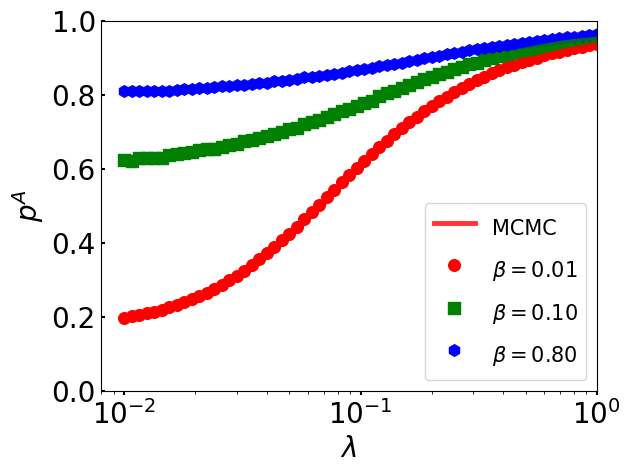

In [22]:
index_beta = [0,32,60]
# lam 可视化
lam_data = lam_values
data1 = pA_mcmc[index_beta[0]]
data2 = pA_mcmc[index_beta[1]]
data3 = pA_mcmc[index_beta[2]]

data1_mmca = pA_mmca[index_beta[0]]
data2_mmca = pA_mmca[index_beta[1]]
data3_mmca = pA_mmca[index_beta[2]]

fig, ax = plt.subplots()

ax.plot(lam_data, data1, color='red', linewidth=3.5, linestyle='-', label='MCMC', alpha=0.8)
ax.scatter(lam_data, data1_mmca, color='red', s=70,  marker='o',
           label=r'$\beta = $'+f'{lam_data[index_beta[0]]:.2f}', )

ax.plot(lam_data, data2, color='green', linewidth=3.5, linestyle='-', alpha=0.8)
ax.scatter(lam_data, data2_mmca, color='green', s=70,  marker='s',
           label= r'$\beta = $'+f'{lam_data[index_beta[1]]:.2f}')

ax.plot(lam_data, data3, color='blue', linewidth=3.5, linestyle='-', alpha=0.8)
ax.scatter(lam_data, data3_mmca, color='blue', s=70,  marker='h',
           label= r'$\beta = $'+f'{lam_data[index_beta[2]]:.2f}')

# # 添加箭头
# ax.annotate('', xy=(25, 0.8), xytext=(25, 0.2),
#             arrowprops=dict(facecolor='gray', shrink=0.1))

# 添加文本标签
# ax.text(40, 0.10, r'$p_{SA}$', fontsize=25, color='black')

# ax.text(0.3, 0.70, r'$\beta = $'+f'{lam_data[index_beta[0]]:.2f}', fontsize=20, color='red')
# ax.text(0.3, 0.60, r'$\beta = $'+f'{lam_data[index_beta[1]]:.2f}', fontsize=20, color='green')
# ax.text(0.3, 0.50, r'$\beta = $'+f'{lam_data[index_beta[2]]:.2f}', fontsize=20, color='blue')

plt.xscale('log')
# plt.yscale('log')
# 设置坐标轴标签
ax.set_xlabel(r'$\lambda$', fontsize=20, color='black')
ax.set_ylabel(r'$p^{A}$', fontsize=20, color='black')
ax.tick_params(axis='x', labelsize=20, length=3, width=1.5, color='black', direction='out')
ax.tick_params(axis='y', labelsize=20, length=3, width=1.5, color='black', direction='in')
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

# 设置顶部文字
# ax.text(-0.15, 1.05, '(a)', fontsize=20, transform=ax.transAxes)
ax.legend(fontsize=15, handlelength=2, handleheight=2)

# 显示图形
plt.show()

fig.savefig(f'../figs/Num_verification/features_times_lam.svg', bbox_inches='tight')